In [1]:
# Basic
import numpy as np
import pandas as pd
# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
# Clustering
from sklearn.manifold import TSNE
from sklearn import cluster
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool

In [2]:
%matplotlib inline
output_notebook()

Loading BokehJS ...

In [6]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
y = df_train.pop('SalePrice') #Take out the 
df = pd.concat([df_train, df_test], axis=0).reset_index()
df.drop('index', axis=1, inplace=True)

print("Training dataset:")
df_train.info(max_cols=0)
print("Testing dataset:")
df_test.info(max_cols=0)
print("Combine two dataset:")
df.info(max_cols=0)

Training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 80 entries, Id to SaleCondition
dtypes: float64(3), int64(34), object(43)
memory usage: 912.6+ KB
Testing dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 80 entries, Id to SaleCondition
dtypes: float64(11), int64(26), object(43)
memory usage: 911.9+ KB
Combine two dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 80 entries, Id to SaleCondition
dtypes: float64(11), int64(26), object(43)
memory usage: 1.8+ MB


I list a few lines of data, so you can have an overall about it

In [5]:
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal


Before performing the TSNE and PCA, I process the numeric and categorical data

In [6]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.values
categorical_cols = df.select_dtypes(include=['object']).columns.values

Here is the numeric columns with the portion of N/A

In [10]:
print('Shape:', df[numeric_cols].shape)
nas = [x for x in df[numeric_cols].columns.values if df[x].isnull().sum() > 0]
print('Cols with NAs:', len(nas))
if len(nas)>0: 
    for x in nas: 
        print(x, ':{:.2f}% of NAs'.format(df[x].isnull().sum()/float(len(df))*100))

('Shape:', (2919, 37))
('Cols with NAs:', 11)
('LotFrontage', ':16.65% of NAs')
('MasVnrArea', ':0.79% of NAs')
('BsmtFinSF1', ':0.03% of NAs')
('BsmtFinSF2', ':0.03% of NAs')
('BsmtUnfSF', ':0.03% of NAs')
('TotalBsmtSF', ':0.03% of NAs')
('BsmtFullBath', ':0.07% of NAs')
('BsmtHalfBath', ':0.07% of NAs')
('GarageYrBlt', ':5.45% of NAs')
('GarageCars', ':0.03% of NAs')
('GarageArea', ':0.03% of NAs')


Same with categorical data with unique value of each columns

In [18]:
print("Shape:", df[categorical_cols].shape)
nas = [x for x in df[categorical_cols].columns.values if df[x].isnull().sum() > 0]
print('Cols with NAs:', len(nas))
if len(nas)>0: 
    for x in nas: 
        print(x, ':{:.2f}% of NAs'.format(df[x].isnull().sum()/float(len(df))*100), '; unique:', df[x].unique())

('Shape:', (2919, 43))
('Cols with NAs:', 23)
('MSZoning', ':0.14% of NAs', '; unique:', array(['RL', 'RM', 'C (all)', 'FV', 'RH', nan], dtype=object))
('Alley', ':93.22% of NAs', '; unique:', array([nan, 'Grvl', 'Pave'], dtype=object))
('Utilities', ':0.07% of NAs', '; unique:', array(['AllPub', 'NoSeWa', nan], dtype=object))
('Exterior1st', ':0.03% of NAs', '; unique:', array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock', nan], dtype=object))
('Exterior2nd', ':0.03% of NAs', '; unique:', array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock', nan], dtype=object))
('MasVnrType', ':0.82% of NAs', '; unique:', array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object))
('BsmtQual', ':2.77% of NAs', '; unique:', array(['Gd

Fill the numerica N/A with median value and drop the 'Id'

In [20]:
X_num = df[numeric_cols].fillna(df.median())
ids = X_num.drop('Id', axis=1)  

Scale the numeric data.

In [ ]:
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns.values) 

Same for categorical data but instead of median, I fill in the string "NA" and make the dummy features

In [24]:
X_cat = df[categorical_cols].fillna('NA')
list_of_dummies = []
for col in [categorical_cols]:
    dum_col = pd.get_dummies(X_cat[col], prefix=col)
    list_of_dummies.append(dum_col)
X_cat = pd.concat(list_of_dummies, axis=1)
X_cat.head(2)

Merge the numeric data and dummy features data

In [28]:
X = pd.concat([X_num_scaled, X_cat], axis=1)
X.info(max_cols=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 312 entries, Id to SaleCondition_Partial
dtypes: float64(312)
memory usage: 6.9 MB


### T-SNE

In [33]:
tsne = TSNE(init='random', perplexity=40, learning_rate=1000, early_exaggeration=8.0, n_iter=1000, random_state=0, metric='l2')
tsne_representation = tsne.fit_transform(X)

In [34]:
cl = cluster.AgglomerativeClustering(3)
cl.fit(tsne_representation);

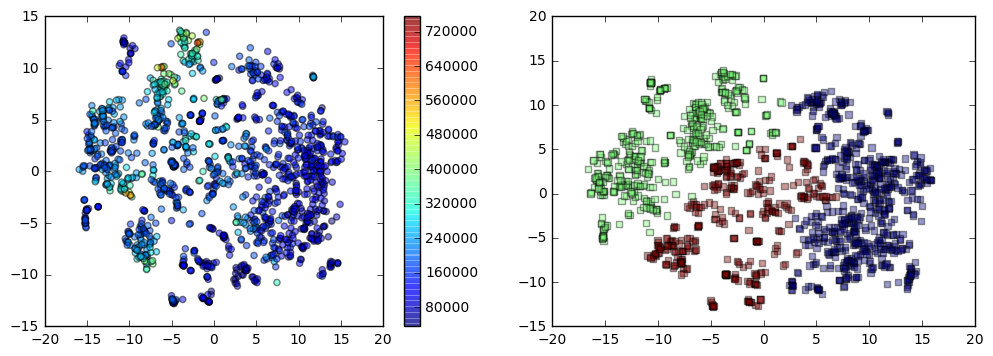

In [35]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
cmap = plt.cm.get_cmap('jet')
plt.scatter(tsne_representation[:len(y),0], tsne_representation[:len(y),1], alpha=0.5, c=y, cmap=cmap, s=20)
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(tsne_representation[len(y):,0], tsne_representation[len(y):,1], alpha=0.4, c=cl.labels_[len(y):], marker='s', s=20)

In [36]:
source_train = ColumnDataSource(
        data=dict(
            x = tsne_representation[:len(y),0],
            y = tsne_representation[:len(y),1],
            desc = y,
            colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 
                      255*mpl.cm.jet(mpl.colors.Normalize()(y.values))],
            OverallQual = df['OverallQual'].iloc[:len(y)],
            GrLivArea = df['GrLivArea'].iloc[:len(y)],
            GarageCars = df['GarageCars'].iloc[:len(y)]
        )
    )

source_test = ColumnDataSource(
        data=dict(
            x = tsne_representation[len(y):,0],
            y = tsne_representation[len(y):,1],
            OverallQual = df['OverallQual'].iloc[len(y):],
            GrLivArea = df['GrLivArea'].iloc[len(y):],
            GarageCars = df['GarageCars'].iloc[len(y):]
        )
    )

hover_tsne = HoverTool(names=["test", "train"], tooltips=[("Price", "@desc"), 
                                 ("OverallQual", "@OverallQual"), 
                                 ("GrLivArea", "@GrLivArea"), 
                                 ("GarageCars", "@GarageCars")])
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=600, plot_height=600, tools=tools_tsne, title='Prices')

plot_tsne.square('x', 'y', size=7, fill_color='orange', alpha=0.9, line_width=0, source=source_test, name="test")
plot_tsne.circle('x', 'y', size=10, fill_color='colors', alpha=0.5, line_width=0, source=source_train, name="train")

show(plot_tsne)

### PCA

In [37]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA()
pca_preresentation = pca.fit_transform(X)

What the PCA does is construct new variables (or principal components) that explain most of the variance or scatter of the original dataset. Each component is a linear combination of all the variables and is perpendicular to every other component. Each variable in each component is multiplied by set of factors, the loading factors, which transforms the original data into this new component space. These loading factors are constrained so that the square of the sum is equal to 1, hence they can serve as weights to see which parameters are most important for a particular principal component.

In [41]:
cl = cluster.AgglomerativeClustering(3)
cl.fit(pca_preresentation)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=3,
            pooling_func=<function mean at 0x00000000042379E8>)

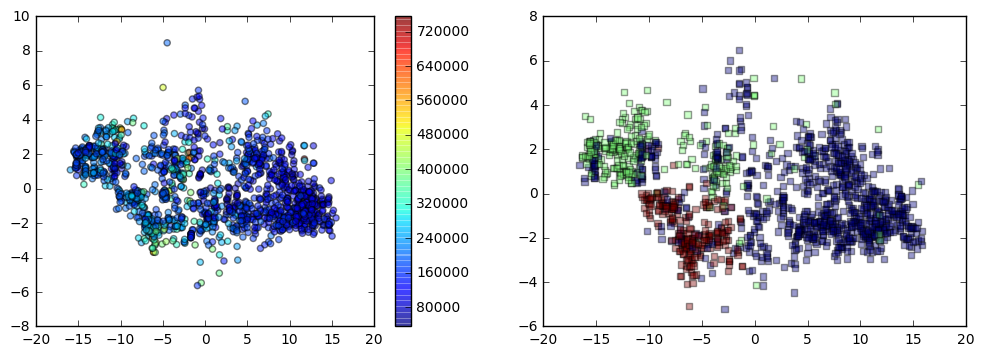

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
cmap = plt.cm.get_cmap('jet')
plt.scatter(tsne_representation[:len(y),0], pca_preresentation[:len(y),1], alpha=0.5, c=y, cmap=cmap, s=20)
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(tsne_representation[len(y):,0], pca_preresentation[len(y):,1], alpha=0.4, c=cl.labels_[len(y):], marker='s', s=20)

In [45]:
source_train = ColumnDataSource(
        data=dict(
            x = pca_preresentation[:len(y),0],
            y = pca_preresentation[:len(y),1],
            desc = y,
            colors = ["#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 
                      255*mpl.cm.jet(mpl.colors.Normalize()(y.values))],
            OverallQual = df['OverallQual'].iloc[:len(y)],
            GrLivArea = df['GrLivArea'].iloc[:len(y)],
            GarageCars = df['GarageCars'].iloc[:len(y)]
        )
    )

source_test = ColumnDataSource(
        data=dict(
            x = pca_preresentation[len(y):,0],
            y = pca_preresentation[len(y):,1],
            OverallQual = df['OverallQual'].iloc[len(y):],
            GrLivArea = df['GrLivArea'].iloc[len(y):],
            GarageCars = df['GarageCars'].iloc[len(y):]
        )
    )

hover_pca = HoverTool(names=["test", "train"], tooltips=[("Price", "@desc"), 
                                 ("OverallQual", "@OverallQual"), 
                                 ("GrLivArea", "@GrLivArea"), 
                                 ("GarageCars", "@GarageCars")])
tools_pca = [hover_pca, 'pan', 'wheel_zoom', 'reset']
plot_pca = figure(plot_width=600, plot_height=600, tools=tools_pca, title='Prices')

plot_pca.square('x', 'y', size=7, fill_color='orange', alpha=0.9, line_width=0, source=source_test, name="test")
plot_pca.circle('x', 'y', size=10, fill_color='colors', alpha=0.5, line_width=0, source=source_train, name="train")

show(plot_tsne)

### Notes:

PCA outputs a function to map from the high-dimension data to low-dimension data, but t-sne does not. This is why t-sne fits into the category of manifold methods where you get a low-dimension representation of a certain dataset, but no outputted function to do the same with a new dataset.

First thinking about the objective function of PCA, it seeks to maximize the Rayleigh quotient. Thus, the first PCA factor is the linear combination of your features that has the highest variance (with the constraint that the linear combinations of this coefficient has a norm-2 of value 1). One of the purposes of PCA is to reduce your dimension and capture the structure of your data. However, from the PCA objective function, we know that the PCA can only capture linear structures in the features. The t-SNE algorithm works in a very different way and focuses to preserve the local distances of the high-dimensional data in some mapping to low-dimensional data.